# Employee Attrition Risk Assessment

---

This project aims to quantify employee attrition risks at an organisation using two survival analytic models: Cox Proportional Hazards regression (CoxPH) and Random Survival Forests (RSF). Recommended intervention strategies are also proposed.

### Data Source

Our dataset is sourced from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), made available under [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and [Database Content License](https://opendatacommons.org/licenses/dbcl/1.0/).

### Analysis Tool

We will be using R for our data analysis, including packages such as `survival` and `randomForestSRC` for modelling, as well as`DataExplorer`,`ggplot2`, `reshape2`, `corrplot`, `pec` and `plotly`.

## Importing Data

We set aside some verificational data to measure our performance.

In [1]:
# Importing data
rm(list = ls())
DATA <- read.csv("hr_data.csv")

# Save some for verification
set.seed(100)
SIZE <- round(0.1*nrow(DATA))
RAND <- sample(1:nrow(DATA))
VERI <- DATA[RAND[1:SIZE], ]
row.names(VERI) <- 1:nrow(VERI)
hr <- DATA[-RAND[1:SIZE], ]
row.names(hr) <- 1:nrow(hr)
#set.seed(NULL)

---

## Performing Data Cleaning

Firstly, we will perform some checks and exploration on our data in order to find patterns that may disrupt our models. Below is the code to show the dataset preview, data types, ranges and shapes, missing values as well as duplicates and outliers.

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


'data.frame':	1323 obs. of  35 variables:
 $ Age                     : int  41 49 37 33 27 32 59 30 38 36 ...
 $ Attrition               : chr  "Yes" "No" "Yes" "No" ...
 $ BusinessTravel          : chr  "Travel_Rarely" "Travel_Frequently" "Travel_Rarely" "Travel_Frequently" ...
 $ DailyRate               : int  1102 279 1373 1392 591 1005 1324 1358 216 1299 ...
 $ Department              : chr  "Sales" "Research & Development" "Research & Development" "Research & Development" ...
 $ DistanceFromHome        : int  1 8 2 3 2 2 3 24 23 27 ...
 $ Education               : int  2 1 2 4 1 2 3 1 3 3 ...
 $ EducationField          : chr  "Life Sciences" "Life Sciences" "Other" "Life Sciences" ...
 $ EmployeeCount           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : int  1 2 4 5 7 8 10 11 12 13 ...
 $ EnvironmentSatisfaction : int  2 3 4 4 1 4 3 4 4 3 ...
 $ Gender                  : chr  "Female" "Male" "Male" "Female" ...
 $ HourlyRate              : int  94 61 92 56 40 79 8

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1323        Length:1323        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 467.5  
 Median :36.00   Mode  :character   Mode  :character   Median : 804.0  
 Mean   :36.99                                         Mean   : 804.1  
 3rd Qu.:43.00                                         3rd Qu.:1162.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1323        Min.   : 1.000   Min.   :1.000   Length:1323       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.143   Mean   :2.905                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

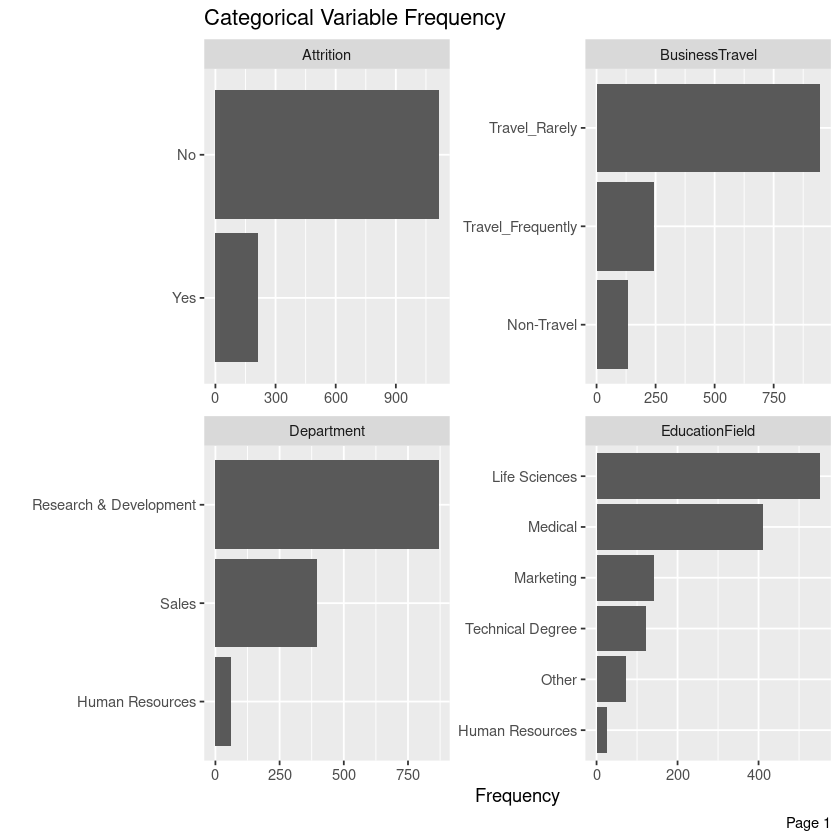

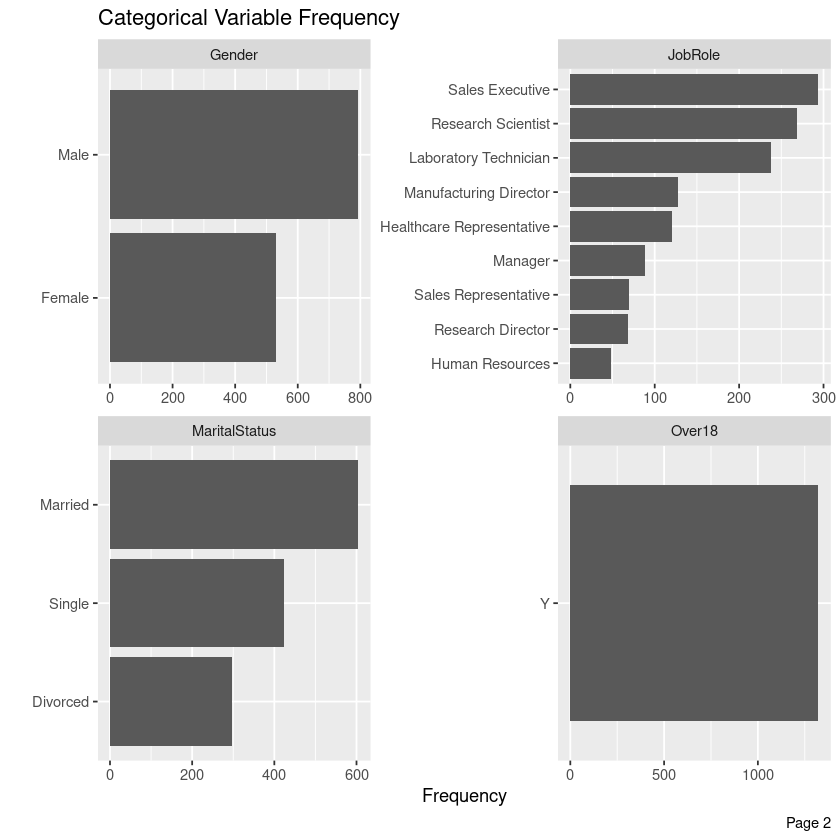

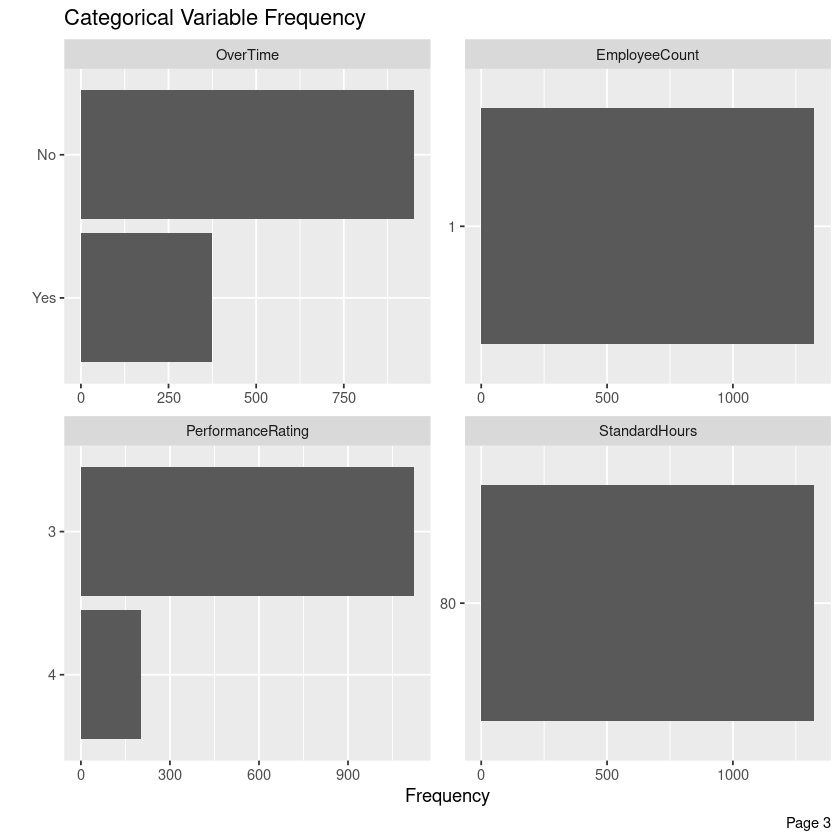

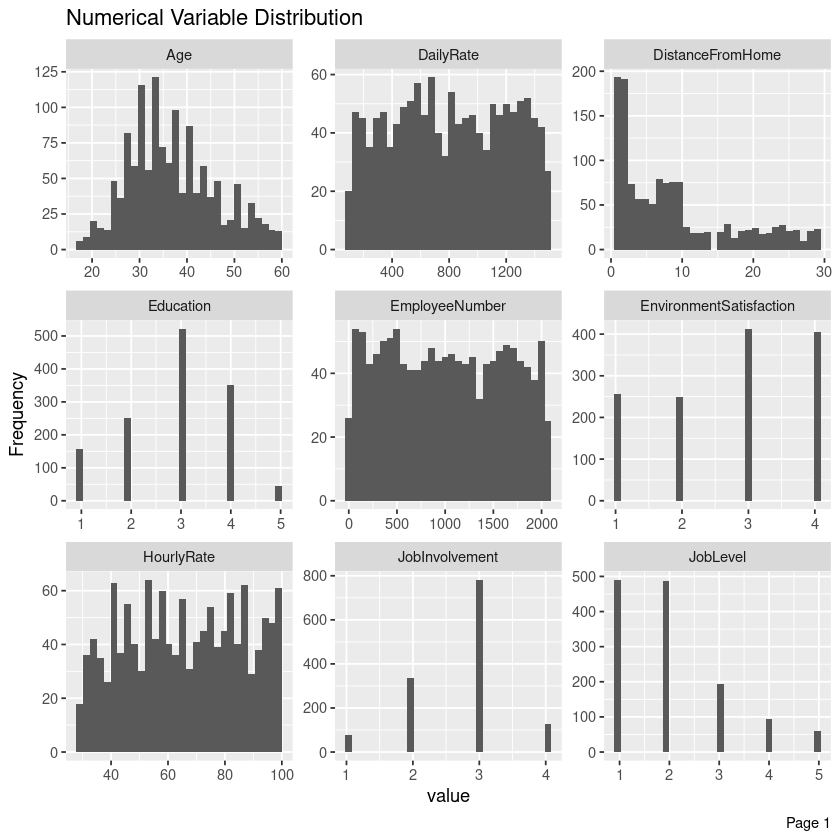

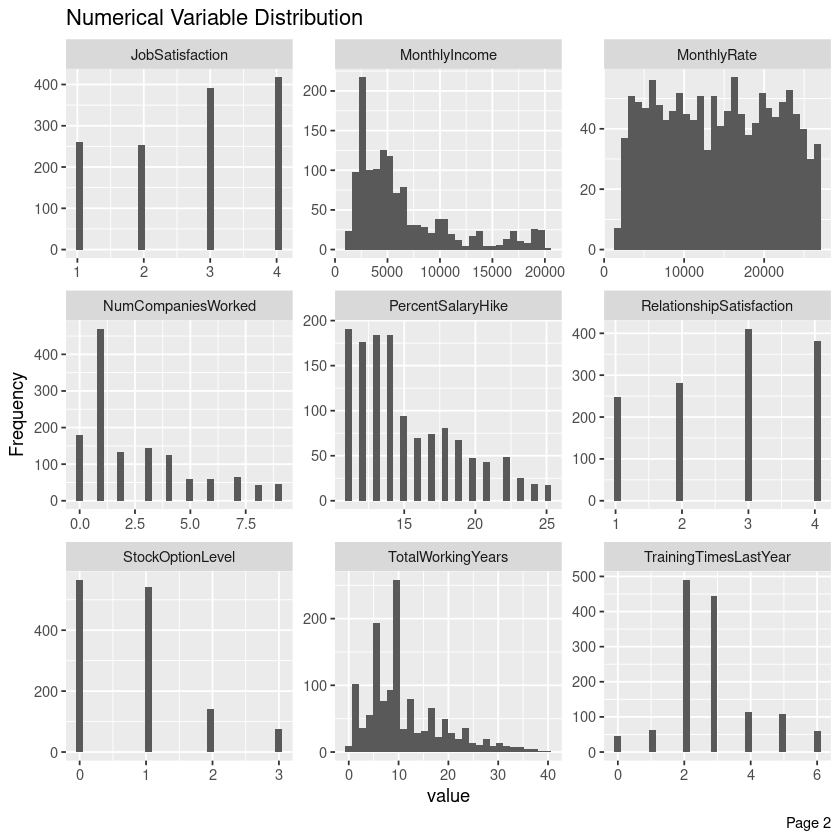

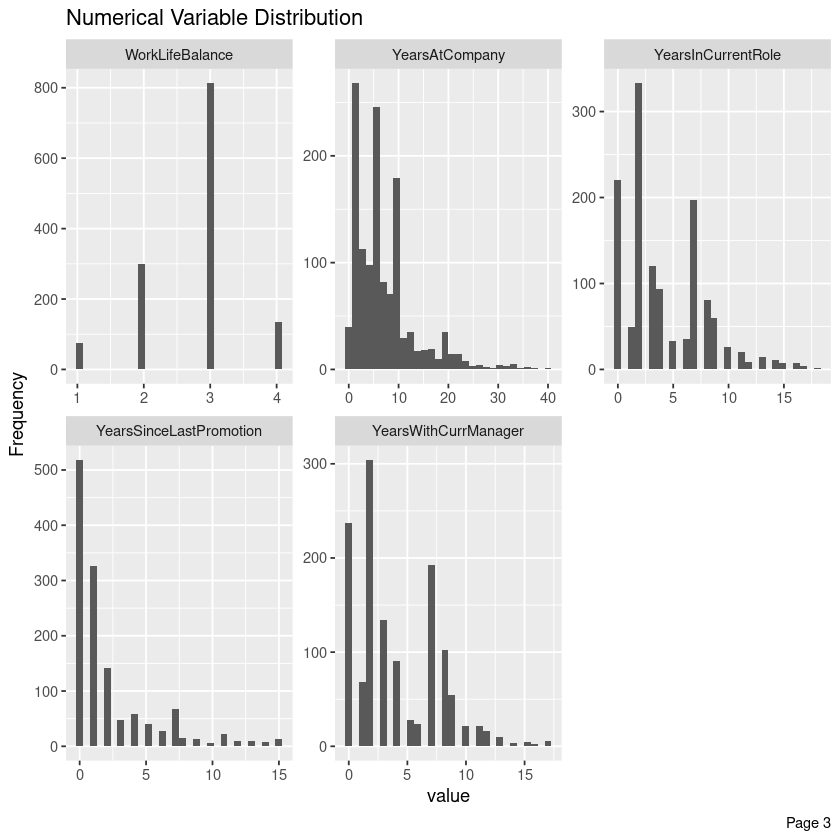

[1] 0

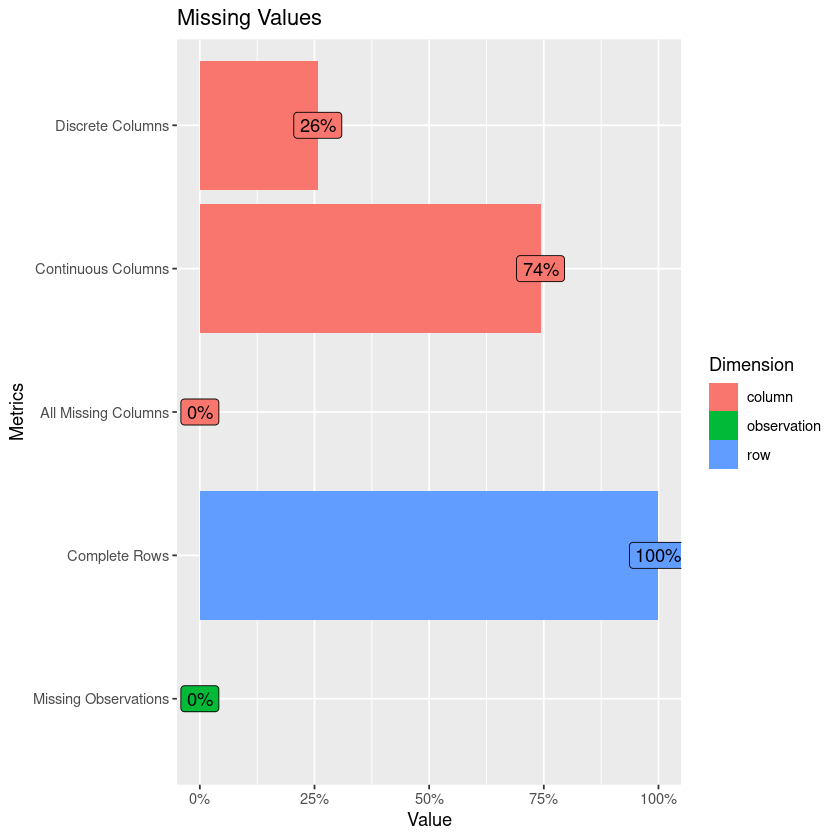

In [2]:
library(DataExplorer)

# First few rows
head(hr)
# All columns' types, ranges and freq/dist
str(hr)
summary(hr)
plot_bar(hr, title = "Categorical Variable Frequency", nrow = 2, ncol = 2)
plot_histogram(hr, title = "Numerical Variable Distribution", nrow = 3, ncol = 3)

# Info about missingk values and duplicates
plot_intro(hr, title = "Missing Values")
sum(duplicated(hr))

There are several noticable things from our exploratory output above:

1. `Attrition` and `YearsAtCompany` are our variables of interest for survival analysis, while `EmployeeNumber` is the unique identification variable.

2. There are three single-valued variables (`EmployeeCount`, `Over18`, `StandardHours`) which cannot be considered for building a risk model. We will filter these variables along with `EmployeeNumber` via column name list to retain the original dataset.

3. All string variables are categorical, three of which (`Attrition`, `Over18`, `OverTime`) are semantically Boolean. For clarity, we can format their type as such.

4. All numerical features are integers, which for the purpose of modelling will be treated as continuous. This also includes rating/level variables such as `Education` and `JobInvolvement`.

5. There seems to be no issues with missing values, duplicates or visibly-outlier points.

Some more nuanced observations:

1. The numerical variables seem to be distributed mostly like a right-skewed bell curve, with a few exceptions. The variables `DailyRate`, `MonthlyRate` and `HourlyRate` seem to be uniformly distributed which is very unusual. This might be accidentally introduced in our synthetic data creation. For this reason, we filter these columns from our consideration.

2. My separate exploration indicates some potential cross-column consistency issues on temporal columns (`Age`, `TotalWorkingYears`, `Years...`), such as whether a column should be larger/equal to another. But I was not able to verify this due to the lack of complete column descriptions. We are therefore skipping cleaning this aspect. I also make an assumption that the zero values in these columns (particularly `YearsAtCompany`) mean a round-down of "six months or less".

3. The `Attrition` rate is around $10-20\%$, which based on [some online information that I read](https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he?noredirect=1&lq=1) is not enough to pragmatically justify data-imbalance resampling. Adjusting the weights in model's metrics or incorporating external knowledge about minority class into the model could be an alternative for future attempts.

We now perform the data formatting and column filtering:

In [3]:
# Format data types
cat_cols <- c("BusinessTravel", "Department", "Gender", "EducationField", "JobRole", "MaritalStatus")
hr[cat_cols] <- lapply(hr[cat_cols], factor)
bool_cols <- c("Attrition", "Over18", "OverTime")
hr[bool_cols] <- lapply(hr[bool_cols], function (col) { col %in% c("Yes", "Y", "TRUE") })

# Filter irrelevant columns
cols <- names(hr)
cols <- cols[cols != "EmployeeNumber"]
single_value_cols <- names(hr)[sapply(hr, function (col) { length(unique(col)) == 1 })]
cols <- cols[!(cols %in% single_value_cols)]
invalid_unif_cols <- c("DailyRate", "MonthlyRate", "HourlyRate")
cols <- cols[!(cols %in% invalid_unif_cols)]

head(hr[cols])

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,⋯,3,3,0,8,3,3,8,7,3,0
5,27,FALSE,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,⋯,3,4,1,6,3,3,2,2,2,2
6,32,FALSE,Travel_Frequently,Research & Development,2,2,Life Sciences,4,Male,3,⋯,3,3,0,8,2,2,7,7,3,6


Next, we also look at the variable correlations. To prevent data leakage effects into our cross-validation, we will only consider extremely strong correlations in this stage (more than $90\%$), for the purpose of gaining insights for our predictive models.

corrplot 0.92 loaded



,Var1,Var2,value
,<fct>,<fct>,<dbl>
1265,JobLevel,MonthlyIncome,0.9489653
264,DepartmentResearch & Development,DepartmentSales,-0.9026233


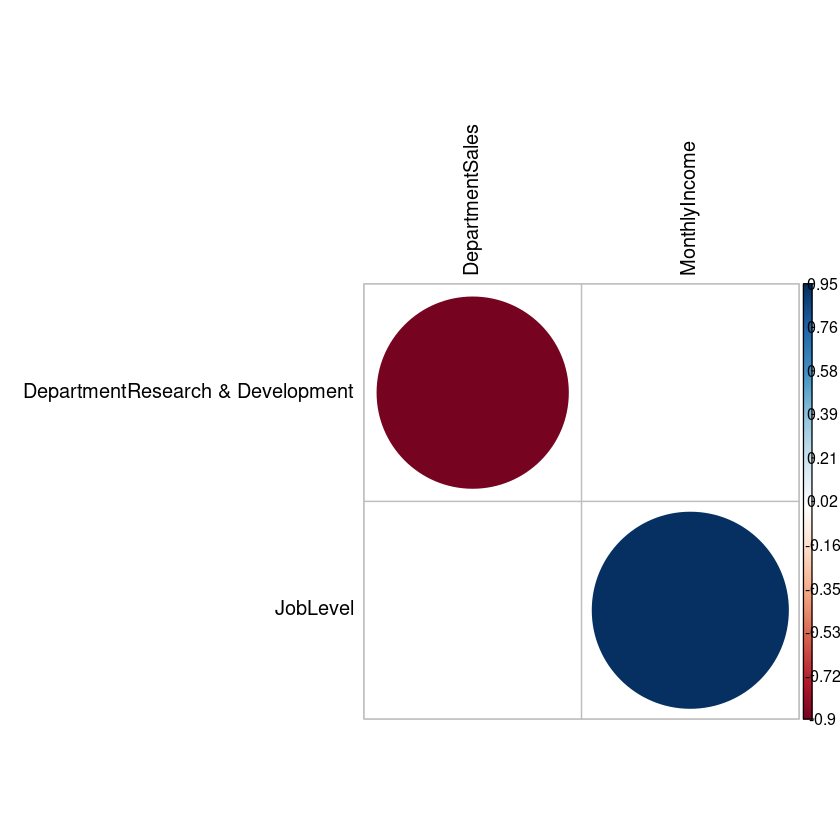

In [4]:
library(reshape2)
library(corrplot)

# === Correlation functions

corr_table <- function (df, limit = 0){
  # Convert categories to dummies
  df2 <- model.matrix(~ 0+., df)

  # Dropping entries
  corr <- cor(df2)
  corr[lower.tri(corr, diag = TRUE)] <- NA
  corr[abs(corr) == 1] <- NA
  
  # Convert to long format, sorted
  res <- melt(corr)
  res <- na.omit(res)
  res <- res[abs(res$value) > limit,]
  res <- res[order(res$value, decreasing = TRUE),]
  return(res)
}

corr_map <- function (df, limit = 0){
  # Detour to corr_table for simplified result
  corr <- acast(corr_table(df, limit), Var1 ~ Var2)
  corrplot(corr, is.corr = FALSE, tl.col = "black", na.label = " ")
}

corr_table(hr[cols], limit = 0.9)
corr_map(hr[cols], limit = 0.9)

The correlation between `MonthlyIncome` and `JobLevel` is so strong at above $90\%$, and there is a simple, non-coincidental explanation for this: higher job responsibilities should be rewarded higher. Since high correlation may lead to high error variance in Cox model and redundancy in Random Survival Forest model, we exclude `JobLevel` and only include `MonthlyIncome` in our features.

The correlation on `Department` merely tells us that it resembles a binary option between `R&D` and `Sales` (since there are three categories of `Department`). We can classify the minor `HR` with `Sales`, but I do not think it will improve the model speed much.

By domain knowledge, time-dependent covariates such as `Age`, `TotalWorkingYears`, `YearsInCurrentRole`, `YearsWithCurrManager` and `YearsSinceLastPromotion` are very likely to be collinear with each other, including the survival time `YearsAtCompanies` (a separate check on our data shows around $70\%$ correlation). For a similar reason as before, we exclude these columns and substitute them with `NotWorkingYears` and `YearsAtOtherCompanies`.

In [5]:
# Removing highly-correlated variables
high_cor_cols <- c("Age", "JobLevel", "TotalWorkingYears", "YearsWithCurrManager",
                   "YearsInCurrentRole", "YearsSinceLastPromotion")
cols <- cols[!(cols %in% high_cor_cols)]

# Adding new non-correlated time variables
new_time_cols <- c("NotWorkingYears", "YearsAtOtherCompanies")
cols <- c(cols, new_time_cols)
hr["NotWorkingYears"] <- hr["Age"] - hr["TotalWorkingYears"]
hr["YearsAtOtherCompanies"] <- hr["TotalWorkingYears"] - hr["YearsAtCompany"]

---

## Developing Survival Models

We utilise Cox Proportional Hazard and Random Survival Forest models, available from R's library `Survival` and `randomForestSRC`. These models offer distinct approaches: CoxPH model is commonly used in statistical analysis due to its interpretability and generalisation, allowing researchers to assess the contribution of variables and generate event's theoretical framework. Meanwhile, RSF is a powerful machine learning algorithm with embedded feature selection capabilities such as variable importance, which is able to incorporate non-linear relationships.

A [comparative research on high-dimensional data](https://www.nature.com/articles/s41598-020-77220-w) indicates that CoxPH with univariate concordance index's (C-index) feature selection and RSF with variable importance's feature selection perform quite well on empirical data. As a result, we are pairing both models with aforementioned feature selection methods.

We use concordance index (C-index) and Prediction Error Curve (PEC, i.e. integrated Brier score) to measure models' accuracy. The `YearsAtCompany` is set as survival time variable, and `Attrition` as status variable.

Below is the code for various functions used in our modelling:

In [6]:
library(survival)
suppressMessages(library(randomForestSRC))
library(ggplot2)
suppressMessages(library(pec))

# === Models

coxph_model <- function (df) {
  model <- coxph(data = df, formula = Surv(YearsAtCompany, Attrition) ~ ., method = "breslow", x = TRUE)
  return(model)
}

rsf_model <- function (df) {
  model <- rfsrc(Surv(YearsAtCompany, Attrition) ~ ., data = df, ntree = 100, block.size = 1)
  return(model)
}

In [7]:
# === Feature selection

# 1. Cox score

coxph_score <- function (df, model) { # ignore the model
  features <- names(df)[!(names(df) %in% c("Attrition", "YearsAtCompany"))]
  scores <- sapply(features, function (col){
    summary(coxph_model(df[c("YearsAtCompany", "Attrition", col)]))$concordance[1]
  })
  names(scores) <- features
  return(scores)
}

coxph_details <- function (model) {
  return(summary(model)$coefficients[, c("exp(coef)", "coef", "se(coef)")])
}

# 2. RSF Importance
rsf_importance <- function (df, model) {
  return(predict(model, df, importance = TRUE)$importance)
}


# ===

print_coxph_var_rank <- function (df) {
  print("Univariate Cox score:")
  res <- coxph_score(df, coxph_model(df))
    # SOON: 1D line
  print(res[order(res, decreasing = TRUE)])
}

print_rsf_var_rank <- function (df) {
  print("Variable importance:")
  res <- rsf_importance(df, rsf_model(df))
    # SOON: 1D line
  print(res[order(abs(res), decreasing = TRUE)])
}

In [8]:
# === Accuracy metrics

# 1. C-index
c_index <- function (df, model) {
  c_table <- cindex(model, formula = Surv(YearsAtCompany, Attrition) ~ ., data = df)
  if (unlist(c_table$Pairs) == 0) return(0) # In case of zero events
  return(unlist(c_table$AppCindex))
}

# 2. PEC


# ===

print_c_index <- function(df, model_f) {
  print("Concordance index:")
  print(c_index(df, model_f(df)))
}

plot_pec <- function(df, model_f) { # split???
  suppressMessages(pred_error <- pec(model_f(df), data = df, formula = Surv(YearsAtCompany, Attrition) ~ .,
                    splitMethod = "cv10", cens.model = "marginal", reference = FALSE))
  plot(pred_error, xlim = c(0, 10), ylim = c(0, 0.25)) # 0.25 is the worst case scenario (random model)
  title("Prediction Error Curve")
}

In [9]:
# === Cross-validation function

cross_val <- function (df, model_f, select_f, feature_num = 1, k = 5) {
  random_index <- sample(1:nrow(df))
  performance_score1_vec <- numeric(k)
  for (fold in 1:k) {
    prev_end <- round((fold-1)/k * nrow(df))
    size <- round(fold * nrow(df)/k) - round((fold-1) * nrow(df)/k)
    idx <- random_index[(prev_end+1):(prev_end+size)]
    test <- df[idx, ]
    train <- df[-idx, ]
    
    # Outlier removal
    train <- train[-outlier_index(train, "YearsAtCompany", iqr_coef = 2), ]
    
    # Assumption check
    if (identical(model_f, coxph_model)) {
      cols <- colnames(df)
      focus_cols <- cols[!(cols %in% c("Department", "JobRole"))]
      pht <- proportional_hazard_table(model_f(train[focus_cols]))
      broken_ph_assumption_cols <- names(which(pht$table[, "p"] < 0.01))
      cols <- cols[!(cols %in% broken_ph_assumption_cols)]
      train <- train[cols]
    }

    # Initial model
    model1 <- model_f(train)
    feature_score <- select_f(test, model1)
    feature_rank <- feature_score[order(abs(feature_score), decreasing = TRUE)]
    
    # Correlated columns removal
    feature_redundancy <- corr_table(train, limit = 0.7)
    for (i in 1:nrow(feature_redundancy)) {
      # Retain higher rank, if any
      x <- feature_redundancy[i, "Var1"]
      y <- feature_redundancy[i, "Var2"]
      if (x %in% feature_rank && y %in% feature_rank) {
        x_rank <- which(feature_rank == x)
        y_rank <- which(feature_rank == y)
        feature_rank <- feature_rank[-max(x_rank, y_rank)]
      }
    }
    
    # Next model
    final_features <- names(feature_rank)[1:min(feature_num, length(names(feature_rank)))]
    #print("Choosing features ...")
    #print(final_features)
    model2 <- model_f(df[c("Attrition", "YearsAtCompany", final_features)])
    performance_score1 <- c_index(df, model2)
    # PEC variable soon
    
    performance_score1_vec[fold] <- performance_score1
  }

  print(paste0("Performance score via concordance index, for feature number = ", feature_num, ":"))
  # Box plot soon
  print(paste0("Mean: ", mean(performance_score1_vec)))
  print(performance_score1_vec)
  print(paste0("SE: ", sd(performance_score1_vec)))
}

In [10]:
# === Assumption functions

proportional_hazard_table <- function (model) {
  return(cox.zph(model))
}

outlier_index <- function(df, col, iqr_coef = 0) {
    vec <- df[[col]]
    qnt <- quantile(vec, probs = c(0.25, 0.75))
    iqr <- qnt[2] - qnt[1]
    min <- qnt[1] - iqr_coef * iqr
    max <- qnt[2] + iqr_coef * iqr
    return(which(vec < min | vec > max))
}

### Outliers & Column Independence

In order for our model to generalise well, we need to take care about our target variable's outliers `YearsAtCompany`. For simplicity, we will remove all that above twice the quartile difference.

To prevent data leaking, we separate our data now into a sample training and testing data.

In [11]:
train <- hr[1:round(0.8*nrow(hr)), ]
test <- hr[-(1:round(0.8*nrow(hr))), ]

train <- train[-outlier_index(train, "YearsAtCompany", iqr_coef = 2), ]

We also pre-select features that are at least "moderately" independence. This will avoid multicollinearity which breaks the assumption of CoxPH model, while help to improve performance of RSF model. Survival models are generally robust against correlated covariates, hence the decision for "moderately".

From correlation map, we will keep in mind to choose one of the pairs when performing feature selection.

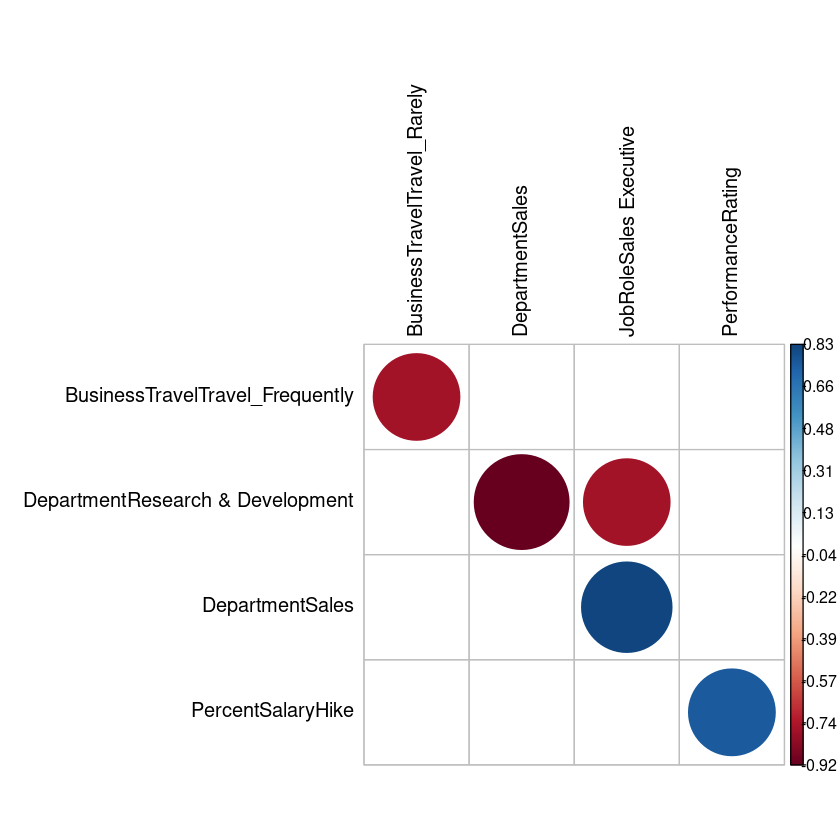

In [12]:
tr1 <- train[cols]
corr_map(tr1, limit = 0.7)

## Cox Proportional Hazard: Feature Selection

There is another assumption of proportional hazard for CoxPH, which can be checked by performing statistical test on Schoenfeld residuals. The error message from `check_proportional_hazard()` suggests that `Department` and `JobRole` should be taken out from the test due to large fitted coefficients, although we will still include in the feature selection.

The result below, and a separate look at the residual plots, suggest that `MonthlyIncome` violates this assumption. We remove these from our features when fitting our initial model.

In [13]:
focus_cols <- cols[!(cols %in% c("Department", "JobRole"))]
proportional_hazard_table(coxph_model(train[focus_cols]))

coxph_cols <- cols[!(cols %in% c("MonthlyIncome"))]

                            chisq df       p
BusinessTravel           2.58e+00  2   0.276
DistanceFromHome         5.70e-02  1   0.811
Education                4.17e-01  1   0.518
EducationField           2.09e+00  5   0.837
EnvironmentSatisfaction  1.46e-01  1   0.703
Gender                   8.38e-01  1   0.360
JobInvolvement           7.26e-02  1   0.788
JobSatisfaction          1.25e-02  1   0.911
MaritalStatus            2.72e+00  2   0.257
MonthlyIncome            2.17e+01  1 3.2e-06
NumCompaniesWorked       2.13e+00  1   0.144
OverTime                 6.72e-01  1   0.412
PercentSalaryHike        9.30e-01  1   0.335
PerformanceRating        6.09e-01  1   0.435
RelationshipSatisfaction 2.11e-04  1   0.988
StockOptionLevel         1.16e-01  1   0.734
TrainingTimesLastYear    3.75e+00  1   0.053
WorkLifeBalance          8.17e-02  1   0.775
NotWorkingYears          4.54e-03  1   0.946
YearsAtOtherCompanies    3.36e-01  1   0.562
GLOBAL                   3.87e+01 26   0.052

Now we try our first iteration below. The concordance index of the initial model on training set with all (feasible) columns selected is around $80\%$, with the PEC graph showing that our model has averagely around $92\%$ accuracy ($8\%$ error) in describing employee attrition within the span of 10 years.

[1] "Univariate Cox score:"
                 JobRole                 OverTime         StockOptionLevel 
               0.7377978                0.6350304                0.6257363 
           MaritalStatus           JobInvolvement  EnvironmentSatisfaction 
               0.6174888                0.5965297                0.5865085 
         JobSatisfaction           BusinessTravel                Education 
               0.5620114                0.5560562                0.5554310 
          EducationField       NumCompaniesWorked                   Gender 
               0.5475216                0.5421359                0.5394454 
         WorkLifeBalance RelationshipSatisfaction         DistanceFromHome 
               0.5382831                0.5360047                0.5340736 
       PercentSalaryHike    TrainingTimesLastYear        PerformanceRating 
               0.5246221                0.5165598                0.5160180 
              Department    YearsAtOtherCompanies          N

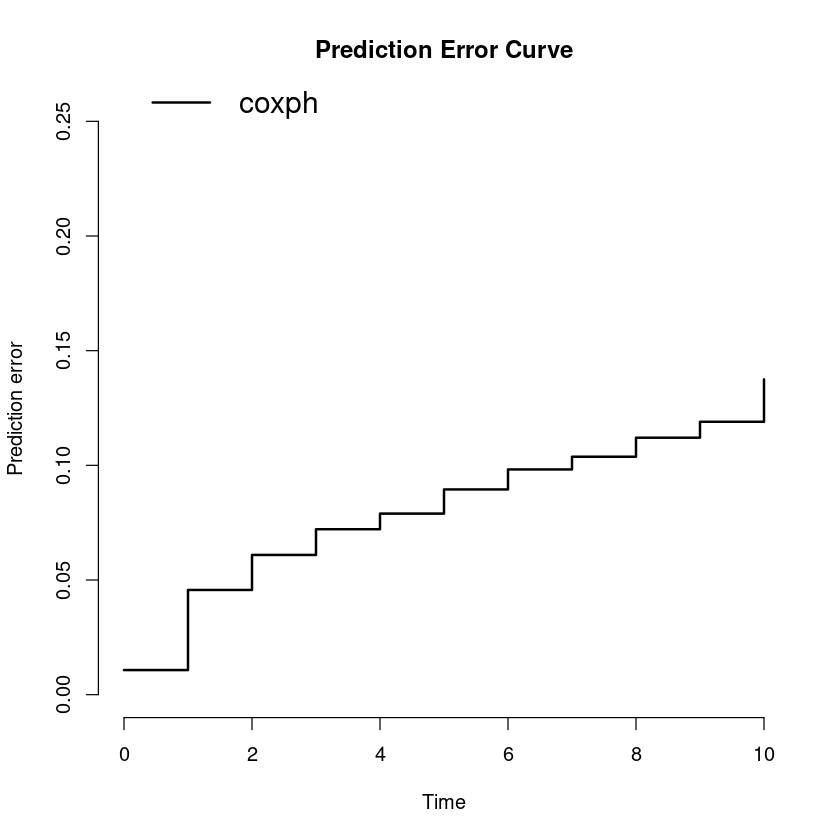

In [14]:
# First iteration
options(warn = -1) # Suppress warnings due to big coxph coefficients

tr1c <- train[coxph_cols]
print_coxph_var_rank(tr1c)

print_c_index(tr1c, coxph_model)
plot_pec(tr1c, coxph_model)

options(warn = 0) # Reactivate warnings

We can see that (under this particular seed) `JobRole` has much higher univariate concordance index compared to others. By taking heuristics that a difference of less than 1% as *not powerful enough*, and considering the benchmark c-index of 0.5 (achieved by a random assigner model), it seems that top-4 covariates (in this case: `JobRole`, `OverTime`, `StockOptionLevel` and `MaritalStatus`) seem like a good idea for feature selection.

**The tuning of the number of features in CoxPH seems to suggest that picking top-4 variables will hit the balance between increased accuracy and simplicity (at around c-index $\approx$ 70\%).**

In [15]:
options(warn = -1) 

for (feature_num in 1:8) {
    cross_val(hr[cols], coxph_model, coxph_score, feature_num) 
}

options(warn = 0)

[1] "Performance score via concordance index, for feature number = 1:"
[1] "Mean: 0.652699037682179"
[1] 0.6512092 0.6586585 0.6512092 0.6512092 0.6512092
[1] "SE: 0.00333144988341205"
[1] "Performance score via concordance index, for feature number = 2:"
[1] "Mean: 0.646262968759949"
[1] 0.646263 0.646263 0.646263 0.646263 0.646263
[1] "SE: 0"
[1] "Performance score via concordance index, for feature number = 3:"
[1] "Mean: 0.679802891095982"
[1] 0.6830646 0.6617180 0.6664146 0.6982252 0.6895920
[1] "SE: 0.0154285148880259"
[1] "Performance score via concordance index, for feature number = 4:"
[1] "Mean: 0.685705535805312"
[1] 0.6633117 0.6797038 0.7186804 0.6832277 0.6836041
[1] "SE: 0.0202200452866165"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.680187541326456"
[1] 0.6500407 0.6500407 0.6870797 0.7046471 0.7091295
[1] "SE: 0.0287274674500669"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.709983439001168"


## Random Survival Forest: Feature Selection

We develop Random Survival Forest model for our data now. The number of trees used in RSF is on the lower scale (100) for faster process. Note that there is no proportional hazard assumption here, so the initial feature set can be incorporated here.

The concordance index is extremely high at around $90\%$, with PEC error under $7.5\%$ across ten years.

[1] "Variable importance:"
           MonthlyIncome                 OverTime  EnvironmentSatisfaction 
             0.258563152              0.166692710              0.075418517 
                 JobRole         StockOptionLevel       NumCompaniesWorked 
             0.063694099              0.045595976              0.038436866 
          JobInvolvement          WorkLifeBalance            MaritalStatus 
             0.036532979              0.035023393              0.031829230 
         NotWorkingYears          JobSatisfaction           EducationField 
             0.026657163              0.025181845              0.022074949 
RelationshipSatisfaction         DistanceFromHome    TrainingTimesLastYear 
             0.020149588              0.018889468              0.018426632 
          BusinessTravel    YearsAtOtherCompanies        PercentSalaryHike 
             0.017491822              0.017254692              0.013463366 
               Education               Department            

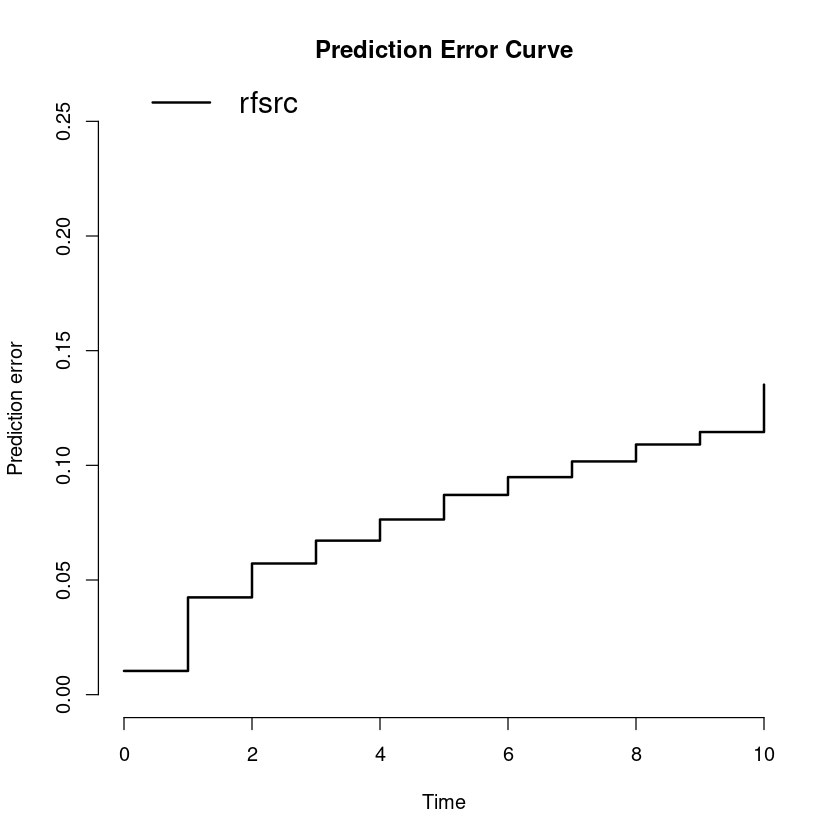

In [16]:
# First iteration
tr1r <- train[cols]
print_rsf_var_rank(tr1r)

print_c_index(tr1r, rsf_model)
plot_pec(tr1r, rsf_model)

The prominently important features in RSF are `MonthlyIncome` and `OverTime`. Other features such as `EnvironmentSatisfaction` `JobRole`, `MaritalStatus` also appear influential. The variable `JobRole` is a categorical data with several levels (i.e. 6), which might bias the RSF algorithm in favor of it.

First preview indicates that top-9 variables might be appropriate, and that we should start cross-validating from two top features.

**Our result below suggests that around 7 to 8 top features in RSF might be a good spot with c-index $\approx$ 85 \%**.

In [17]:
for (feature_num in 2:10) {
    cross_val(hr[cols], rsf_model, rsf_importance, feature_num) 
}

[1] "Performance score via concordance index, for feature number = 2:"
[1] "Mean: 0.800641544398841"
[1] 0.8023936 0.8075129 0.8026072 0.7917274 0.7989667
[1] "SE: 0.00583986480791917"
[1] "Performance score via concordance index, for feature number = 3:"
[1] "Mean: 0.828032136963984"
[1] 0.8194969 0.8193436 0.8267358 0.8459458 0.8286385
[1] "SE: 0.0108545978601474"
[1] "Performance score via concordance index, for feature number = 4:"
[1] "Mean: 0.83203142477587"
[1] 0.8415949 0.8244764 0.8336770 0.8241431 0.8362658
[1] "SE: 0.00760596566376169"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.867492789065882"
[1] 0.8623929 0.8666702 0.8711741 0.8674633 0.8697634
[1] "SE: 0.0033687550191135"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.880193535658745"
[1] 0.8915792 0.8763481 0.8810750 0.8742919 0.8776735
[1] "SE: 0.00682601456109745"
[1] "Performance score via concordance index, for feature number = 7:"
[1] "Me

## Completing Final Models

Our final model is formed by two methods of CoxPH and RSF, each with optimal features of four and seven respectively. The features are manually picked based on our initial training data's feature ranking.

In [18]:
coxph_feature_num <- 4
rsf_feature_num <- 7
coxph_cols <- c("Attrition", "YearsAtCompany", "JobRole", "OverTime", "StockOptionLevel", "MaritalStatus")
rsf_cols <- c("Attrition", "YearsAtCompany", "MonthlyIncome", "OverTime", "EnvironmentSatisfaction", "MaritalStatus",
              "JobRole", "NumCompaniesWorked", "WorkLifeBalance")
coxph_final_model <- coxph_model(hr[coxph_cols])
rsf_final_model <- rsf_model(hr[rsf_cols])

## Interlude: Feature Category Impact

Since `JobRole` and `MaritalStatus` appear influential in both CoxPH and RSF models, it is worth checking out which categories have large impact. An easy way to check this is via the full CoxPH summary table, provided in `coxph_details()`. It seems being Sales Reps in particular multiply the hazard ratio by a whopping $12$ times, while Manager and Research Director have a decreased hazard ratio.

In [19]:
coxph_details(coxph_final_model)

,exp(coef),coef,se(coef)
JobRoleHuman Resources,6.0834154,1.8055663,0.4705528
JobRoleLaboratory Technician,6.2888007,1.8387704,0.3833736
JobRoleManager,0.2903297,-1.2367382,0.6302611
JobRoleManufacturing Director,1.1753510,0.1615668,0.4884813
JobRoleResearch Director,0.2580986,-1.3544137,0.8003248
JobRoleResearch Scientist,3.2979040,1.1932871,0.3936082
JobRoleSales Executive,2.7672977,1.0178713,0.3846418
JobRoleSales Representative,12.8592607,2.5540642,0.4125961
OverTimeTRUE,2.9989889,1.0982752,0.1395719
StockOptionLevel,0.8781538,-0.1299335,0.1348497


---

## Quantifying Employee Attrition Risk

We produce the estimated cumulative hazard function (CHF) of attrition for each of our employee $i$ for Random Survival Forest model, and hazard ratio relative to the exponent of mean for Cox Proportional Hazard model.

In particular, the rank for employee risk based on RSF is determined by the long-term CHF for the next five years, since it is commonly the period where companies may conduct review of their structural performance.

In [20]:
# Appending predictions
years = 5
rsf_risk <- predict(rsf_final_model, hr)$chf[, 1 + (0:years)] # matrix
rsf_survival_probs <- predict(rsf_final_model, hr)$survival[, 1 + (0:years)]
hr["Hazard_RSF_in_1yr"] <- rsf_risk[, 2]
hr["HazardRatio_CoxPH"] <- predict(coxph_final_model, hr, type = "risk")

preview_cols <- c("EmployeeNumber", coxph_cols, rsf_cols, "Hazard_RSF_in_1yr", "HazardRatio_CoxPH")

# Table sorted by hazards
cutoff = 20
sorted <- function (df, key_col) {
  df <- df[df["Attrition"] == FALSE, ]
  return(row.names(df)[order(df[, key_col], decreasing = TRUE)][1:cutoff])
}
hr_sorted_rsf <- hr[sorted(hr, "Hazard_RSF_in_1yr"), ]
hr_sorted_coxph <- hr[sorted(hr, "HazardRatio_CoxPH"), ]
head(hr_sorted_rsf[, preview_cols])
head(hr_sorted_coxph[, preview_cols])

,EmployeeNumber,Attrition,YearsAtCompany,JobRole,OverTime,StockOptionLevel,MaritalStatus,Attrition.1,YearsAtCompany.1,MonthlyIncome,OverTime.1,EnvironmentSatisfaction,MaritalStatus.1,JobRole.1,NumCompaniesWorked,WorkLifeBalance,Hazard_RSF_in_1yr,HazardRatio_CoxPH
,<int>,<lgl>,<int>,<fct>,<lgl>,<int>,<fct>,<lgl>,<int>,<int>,<lgl>,<int>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
285,411,FALSE,0,Sales Representative,FALSE,0,Single,FALSE,0,1200,FALSE,4,Single,Sales Representative,1,3,0.6061645,32.410683
146,201,FALSE,1,Laboratory Technician,FALSE,0,Single,FALSE,1,1483,FALSE,2,Single,Laboratory Technician,1,3,0.5783249,15.850392
670,1012,FALSE,0,Research Scientist,FALSE,0,Single,FALSE,0,1051,FALSE,2,Single,Research Scientist,1,3,0.5428325,8.312089
22,30,FALSE,0,Research Scientist,FALSE,0,Single,FALSE,0,1232,FALSE,3,Single,Research Scientist,1,3,0.5283543,8.312089
882,1368,FALSE,0,Laboratory Technician,FALSE,0,Single,FALSE,0,1611,FALSE,4,Single,Laboratory Technician,1,4,0.5213561,15.850392
1183,1839,FALSE,0,Research Scientist,FALSE,0,Single,FALSE,0,1514,FALSE,2,Single,Research Scientist,1,1,0.4301665,8.312089


,EmployeeNumber,Attrition,YearsAtCompany,JobRole,OverTime,StockOptionLevel,MaritalStatus,Attrition.1,YearsAtCompany.1,MonthlyIncome,OverTime.1,EnvironmentSatisfaction,MaritalStatus.1,JobRole.1,NumCompaniesWorked,WorkLifeBalance,Hazard_RSF_in_1yr,HazardRatio_CoxPH
,<int>,<lgl>,<int>,<fct>,<lgl>,<int>,<fct>,<lgl>,<int>,<int>,<lgl>,<int>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
999,1556,FALSE,3,Sales Representative,TRUE,0,Single,FALSE,3,2644,TRUE,3,Single,Sales Representative,3,2,0.27204996,97.19928
1291,2021,FALSE,2,Sales Representative,TRUE,0,Single,FALSE,2,2380,TRUE,3,Single,Sales Representative,1,3,0.30588798,97.19928
634,957,FALSE,18,Laboratory Technician,TRUE,0,Single,FALSE,18,4721,TRUE,4,Single,Laboratory Technician,2,3,0.08668531,47.53515
840,1286,FALSE,4,Laboratory Technician,TRUE,0,Single,FALSE,4,2154,TRUE,4,Single,Laboratory Technician,0,2,0.26814748,47.53515
1015,1586,FALSE,10,Laboratory Technician,TRUE,0,Single,FALSE,10,4723,TRUE,2,Single,Laboratory Technician,1,3,0.07480836,47.53515
1033,1611,FALSE,10,Laboratory Technician,TRUE,0,Single,FALSE,10,5769,TRUE,3,Single,Laboratory Technician,1,3,0.06540901,47.53515


## Visualising with Plotly

We also use Plotly library to derive an interactive visualisation of the list of top $20$ employees at risk, where user can group employees according to several factors describing trends of attrition risks based on various factors.

In [29]:
# Plotly implementation
suppressMessages(library(plotly))

fig <- plot_ly()

# --- Adding traces
# RSF
employee_row_num_wrt_ <- match(1:length(hr_sorted_rsf), hr_sorted_rsf)
for (rank in 1:cutoff) {
  employee_row_num <- as.numeric(rownames(hr_sorted_rsf)[rank])
  employee_row <- hr_sorted_rsf[rank, ]
  x <- 0:years
  y <- rsf_risk[employee_row_num, ]
  fig <- fig %>% add_trace(x = x,
                           y = y,
                           name = employee_row["EmployeeNumber"],
                           type = "scatter", mode = "lines+markers", # Every time you put type, it assign DOMNum = 0
                           marker = list(size = 6),
                           line = list(shape = "spline", width = 2),
                           hovertemplate = paste0("<b>", rank, ". Employee ", employee_row["EmployeeNumber"], "</b>",
                                                 "<br>Year: %{x}",
                                                 "<br>Cumulative risk: %{y:.2f}"),
                           hoverlabel = list(font_size = 16),
                           legendrank = rank,
                           legendgroup = employee_row["EmployeeNumber"],
                           showlegend = TRUE)
}

# CoxPH
fig <- fig %>% add_trace(data = hr_sorted_coxph,
                         x = 1:cutoff,
                         y = ~HazardRatio_CoxPH,
                         type = "bar",
                         marker = list(color = 1:cutoff, colorscale = list(c(0, "#64a1f4"), c(1, "#bfe6b5"))), # blue-green
                         hovertemplate = paste0("<b>%{x}. Employee ", hr_sorted_coxph$EmployeeNumber, "</b>",
                                                "<br>Risk ratio: %{y:.2f}"),
                         hoverlabel = list(bgcolor = "white", font_size = 16),
                         showlegend = FALSE,
                         visible = FALSE)


# --- Decorators
# Including the baseline
avg_cum_hazard <- -log(1-mean(hr[, "Attrition"]))
baseline <- list(
  type = "line", x0 = 0, x1 = 5, y0 = avg_cum_hazard, y1 = avg_cum_hazard,
  line = list(dash = "dash", width = 4, color = "#82A0D8")
)
fig <- fig %>% add_text(
  x = 0.3, y = 0.22,
  text = "Average hazard", textfont = list(family = "sans serif", size = 12),
  showlegend = FALSE
)

# Helper functions to group CHF based on variables
library(RColorBrewer)
unique_index <- function(x) {
  unique_vals <- unique(x)
  first_occur <- integer(length(unique_vals))
  for (i in 1:length(unique_vals)) {
    first_occur[i] <- which(x == unique_vals[i])[1]
  }
  return(first_occur)
}
create_buttons <- function(vars) {
  lapply(vars, function(var) {
    color_num <- 8
    color_palletes <- brewer.pal(color_num, "Set2")
    var_factors <- as.numeric(factor(hr_sorted_rsf[[var]]))
    button <- list(
      method = "restyle",
      label = var,
      args = list(list( # Please read Plotly.js for detailed documentation (not R/Python)
        line.color = color_palletes[var_factors %% color_num + 1],
        marker.color = color_palletes[var_factors %% color_num + 1],
        legendrank = if(var == "EmployeeNumber") 1:cutoff else var_factors,
        legendgroup = hr_sorted_rsf[[var]],
        showlegend = 1:cutoff %in% unique_index(var_factors),
        name = as.character(hr_sorted_rsf[[var]])
      ), 1:cutoff - 1)
    )
    return(button)
  })
}


# --- Setting layout
rsf_layout = list( 
  title = "Top 20 High-Risk Employees, according to RSF's Cumulative Risk in Five Years",
  shapes = list(baseline),
  xaxis = list(title = "Year", range = c(0, 5), zerolinecolor = 'white'),
  yaxis = list(title = "Accummulated Risk over Time", range = c(0, 1), zerolinecolor = 'white'),
  `annotations[1].visible` = TRUE,
  `updatemenus[1].visible` = TRUE
)
coxph_layout = list(
  title = "Top 20 High-Risk Employees, according to Risk Ratio",
  shapes = list(),
  xaxis = list(title = "Employee ID", tickmode = "array", tickvals = 1:cutoff,
               ticktext = hr_sorted_coxph["EmployeeNumber"], zerolinecolor = 'white'),
  yaxis = list(title = "Risk Ratio", zerolinecolor = 'white'),
  `annotations[1].visible` = FALSE,
  `updatemenus[1].visible` = FALSE
)
fig <- fig %>% layout( # do.call soon
  title = "Top 20 High-Risk Employees, according to RSF's Cumulative Risk in Five Years",
  shapes = list(baseline),
  xaxis = list(title = "Year", range = c(0, 5), zerolinecolor = 'white'),
  yaxis = list(title = "Accummulated Risk over Time", range = c(0, 1), zerolinecolor = 'white'),
  margin = list(l = 50, t = 50, b = 50, r = 50),
  plot_bgcolor = '#e5ecf6',
  annotations = list(
    list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 1, xref = "paper", yref = "paper", 
      text = "Method", align = "left", showarrow = FALSE
    ), list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.8, xref = "paper", yref = "paper", 
      text = "Based on", align = "left", showarrow = FALSE
    )
  ),
  updatemenus = list(
    list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.95, xref = "paper", yref = "paper",
      showactive = TRUE,
      buttons = list(
        list(
          label = "Random Survival Forest",
          method = "update",
          args = list(list(visible = c(rep(TRUE, cutoff), FALSE, TRUE)), rsf_layout, 1:(cutoff+2) - 1)
        ),
        list(
          label = "Cox Proportional Hazard",
          method = "update",
          args = list(list(visible = c(rep(FALSE, cutoff), TRUE, FALSE)), coxph_layout, 1:(cutoff+2) - 1)
        )
      )
    ), list(
      xanchor = "left", yanchor = "top", x = -0.5, y = 0.75, xref = "paper", yref = "paper",
      showactive = TRUE,
      buttons = create_buttons(c("EmployeeNumber", "EnvironmentSatisfaction", "JobRole", "MonthlyIncome",
                                 "MaritalStatus", "NumCompaniesWorked", "OverTime", "StockOptionLevel", "WorkLifeBalance"))
    )
  )
)

# Build the HTML widget, only for the case of nbviewer
# Otherwise, simply the line `fig` will suffice
htmlwidgets::saveWidget(as_widget(fig), "plot.html")
IRdisplay::display_html("<iframe seamless src='plot.html' width=1000, height=600></iframe>")
# fig

We can notice that the RSF's risk level tend to increase drastically after one year, which might be partially explained by the mode of one `YearsAtCompany` for historically-attritted employees.

Several employees have risk jump in the long-run, such as Employee $2021$, $2020$ and $1556$. It somewhat overlaps with the top results from CoxPH's hazard level.

---

## Recommended Strategies

### Stay Interviews with High-Risk Employees

Conduct stay interviews with employees to understand their perspectives and needs. Use risk scores to prioritize who to interview, but recognize the limitations of only using a few variables to predict individuals and gain individual perspectives and concerns.

### Career Welfare Support

Survey employees on factors like overtime expectations, work-life balance satisfaction, company culture/environment to gain a holistic understanding beyond data variables. Overtime in particular seems correlated and needs some proper management.

### Targetted Retention Program for Sales Reps

Develop retention programs tailored specifically for sales representations, who showed higher attrition risk compared to other positions. Pilot mentorship matching, expanded training support, career path guidance, or revised compensation incentives focused on these groups. Assess needs periodically and refine programs over time based on attrition trends and feedback.

### Financial Benefits & Compensation

Ensure that compensation and benefits packages are competitive and aligned with industry standards. Consider revising the stock option plans or other incentives to increase employee motivation and loyalty.

---

## Epilogue: Accuracy Check on Data

In [22]:
prepare <- function(df) {
  df[cat_cols] <- lapply(df[cat_cols], factor)
  df[bool_cols] <- lapply(df[bool_cols], function (col) { ifelse(col %in% c("Yes", "Y"), TRUE, FALSE) })
  df["NotWorkingYears"] <- df["Age"] - df["TotalWorkingYears"]
  df["YearsAtOtherCompanies"] <- df["TotalWorkingYears"] - df["YearsAtCompany"]
  df <- df[!(names(df) %in% c("EmployeeNumber", single_value_cols, invalid_unif_cols, high_cor_cols))]
  return(df)
}

VERI_with_features <- prepare(VERI)
print(c_index(VERI_with_features[coxph_cols], coxph_final_model))
print(c_index(VERI_with_features[rsf_cols], rsf_final_model))

   coxph 
0.852528 
    rfsrc 
0.8165372 
